## Time Series Analysis for Revenue Forecasting


## Objective
Forecast future revenue based on historical time series data using statistical and machine learning models.


## Dataset Overview
The dataset contains monthly or daily revenue data, which can be used to identify trends, seasonality, and forecast future values.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

## Workflow
1. Load and explore the dataset  
2. Visualize trends and seasonality  
3. Preprocess the time series data  
4. Apply time series forecasting models  
5. Evaluate model performance


In [2]:
# Load data
df = pd.read_csv(r"C:\Users\hp\Downloads\Finance Work\time_data.csv")

# Parse dd-mm-yyyy and sort by time
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date")

# Set Date as index and ensure monthly end frequency
df = df.set_index("Date")
ts = df["Revenue"].asfreq("M")

# Interpolate if any missing months (safety)
ts = ts.interpolate()

print("Start:", ts.index.min(), " End:", ts.index.max())
print("Number of points:", len(ts))
ts.head()

Start: 2020-01-31 00:00:00  End: 2023-12-31 00:00:00
Number of points: 48


C:\Users\hp\AppData\Local\Temp\ipykernel_23360\2819107874.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df["Revenue"].asfreq("M")


Date
2020-01-31     202
2020-02-29     650
2020-03-31    1020
2020-04-30    1226
2020-05-31    1397
Freq: ME, Name: Revenue, dtype: int64

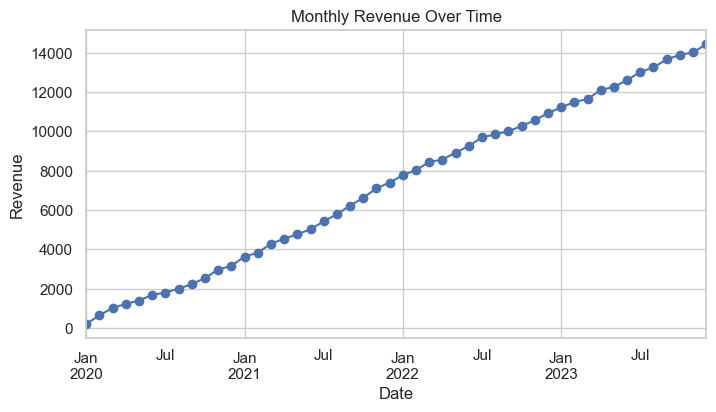

In [3]:
# Plot overall revenue trend
ts.plot(marker="o")
plt.title("Monthly Revenue Over Time")
plt.ylabel("Revenue")
plt.show()

## Data Exploration and Visualization
Visualizing the revenue trend over time and decomposing the series into trend, seasonality, and residual components.


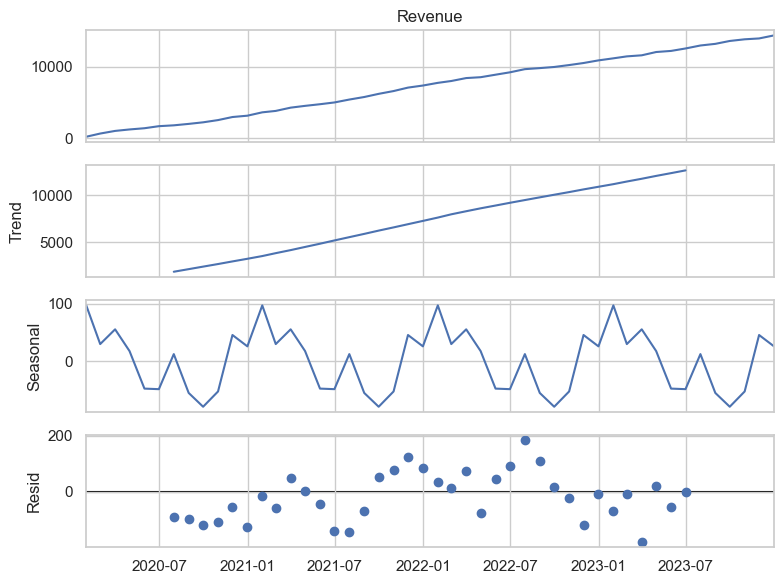

In [4]:
# Seasonal decomposition (additive, yearly seasonality = 12 months)
decomp = seasonal_decompose(ts, model="additive", period=12)

fig = decomp.plot()
fig.set_size_inches(8, 6)
plt.tight_layout()
plt.show()

## Model Training and Forecasting using ARIMA
Applying an ARIMA model to capture the temporal dependencies and forecast future revenue values.


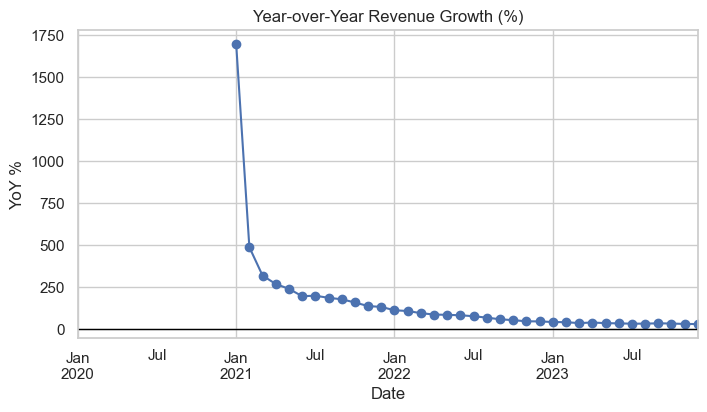

Date
2023-01-31    44.338652
2023-02-28    43.077689
2023-03-31    37.856720
2023-04-30    41.314499
2023-05-31    37.463557
2023-06-30    36.193667
2023-07-31    34.278643
2023-08-31    34.596242
2023-09-30    36.529041
2023-10-31    35.231698
2023-11-30    32.692490
2023-12-31    32.116388
Freq: ME, Name: Revenue, dtype: float64

In [5]:
# Year-over-year % change to see growth rate
yoy_growth = ts.pct_change(12) * 100
yoy_growth.plot(marker="o")
plt.title("Year-over-Year Revenue Growth (%)")
plt.ylabel("YoY %")
plt.axhline(0, color="black", linewidth=1)
plt.show()

yoy_growth.tail(12)

## Conclusion
- ARIMA was applied to forecast future revenue.  
- The model can be fine-tuned for better performance using grid search or other techniques.  
- You may explore advanced models like SARIMA or Prophet for improved accuracy.


## SARIMA model and future forecast

In [6]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load and prepare series
df = pd.read_csv("time_data.csv")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values("Date").set_index("Date")

# Monthly frequency + interpolation (if any gaps)
ts = df["Revenue"].asfreq("M").interpolate()

# Train up to 2022-12, test is 2023-01 onwards
train = ts.loc[: "2022-12-31"]
test = ts.loc["2023-01-31":]

print("Train len:", len(train), " Test len:", len(test))

Train len: 36  Test len: 12


C:\Users\hp\AppData\Local\Temp\ipykernel_23360\3348680175.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df["Revenue"].asfreq("M").interpolate()


In [7]:
# SARIMA(1,1,1)(1,1,1,12) with constant
sarima_model = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    trend="c",
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_res = sarima_model.fit(disp=False)
print(sarima_res.summary())

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -55.559
Date:                            Thu, 04 Dec 2025   AIC                            123.117
Time:                                    16:37:21   BIC                            124.301
Sample:                                01-31-2020   HQIC                           120.564
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -9.9746    112.099     -0.089      0.929    -229.685     209.736
ar.L1         -0.2537      1.714   

In [8]:
# Forecast same length as test
sarima_forecast_test = sarima_res.get_forecast(steps=len(test))
sarima_pred_test = sarima_forecast_test.predicted_mean

# Put actual vs predicted in one DataFrame
sarima_compare = pd.DataFrame({
    "actual": test,
    "sarima_pred": sarima_pred_test
})
sarima_compare

,actual,sarima_pred
2023-01-31,11218,11442.379551
2023-02-28,11492,11614.781869
2023-03-31,11642,12050.020344
2023-04-30,12105,12199.343856
2023-05-31,12259,12478.215726
2023-06-30,12602,12742.124642
2023-07-31,13021,13113.734077
2023-08-31,13251,13307.841131
2023-09-30,13657,13559.998813
2023-10-31,13891,13866.885945


In [9]:
# Forecast 12 months beyond the last observed date
n_steps = 12
sarima_future = sarima_res.get_forecast(steps=n_steps)
sarima_future_mean = sarima_future.predicted_mean

# Create future index (months after last date in ts)
future_index = pd.date_range(
    ts.index[-1] + pd.offsets.MonthEnd(1),
    periods=n_steps,
    freq="M"
)

future_forecast = pd.Series(
    sarima_future_mean.values,
    index=future_index,
    name="SARIMA_forecast"
)

future_forecast

C:\Users\hp\AppData\Local\Temp\ipykernel_23360\501130157.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_index = pd.date_range(


2024-01-31    11442.379551
2024-02-29    11614.781869
2024-03-31    12050.020344
2024-04-30    12199.343856
2024-05-31    12478.215726
2024-06-30    12742.124642
2024-07-31    13113.734077
2024-08-31    13307.841131
2024-09-30    13559.998813
2024-10-31    13866.885945
2024-11-30    14222.902604
2024-12-31    14532.333093
Freq: ME, Name: SARIMA_forecast, dtype: float64

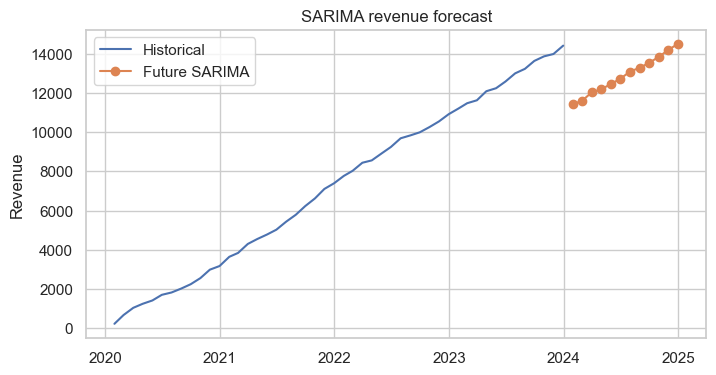

In [10]:
import matplotlib.pyplot as plt

plt.plot(ts.index, ts, label="Historical")
plt.plot(future_forecast.index, future_forecast, label="Future SARIMA", marker="o")
plt.legend()
plt.title("SARIMA revenue forecast")
plt.ylabel("Revenue")
plt.show()